In [1]:
# Simulate a stationary ARMA(2,2) process. Use the ArmaProcess function from statsmodels and simulate this:
#          yt = 0.33yt –1 + 0.50yt –2 + 0.9ϵt –1 + 0.3ϵt –2

In [2]:
# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Generate 10,000 samples 

np.random.seed(42)

ma2 = np.array([1, 0.9, 0.3])
ar2 = np.array([1, -0.33, -0.5])

ARMA_2_2 = ArmaProcess(ar2, ma2).generate_sample(nsample = 10000)

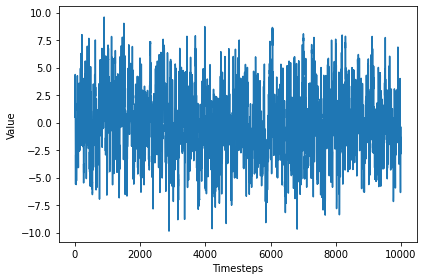

In [4]:
fig, ax = plt.subplots()

ax.plot(ARMA_2_2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

In [5]:
# Run the ADF test and check if the process is stationary
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(ARMA_2_2)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'P-Value: {ADF_result[1]}')

ADF Statistic: -20.684894435243287
P-Value: 0.0


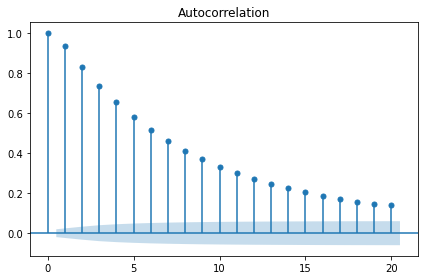

In [6]:
# With a large negative ADF statistic and a p value less than 0.05, we can conclude that the process is stationary
# Check for auto correlation

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ARMA_2_2, lags=20)
plt.tight_layout()

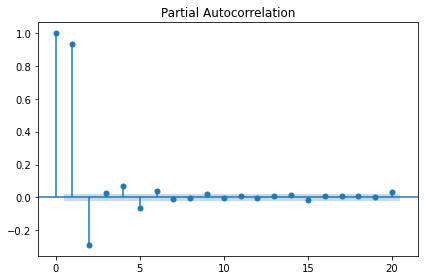

In [7]:
# Check for partial auto correlation

plot_pacf(ARMA_2_2, lags=20)
plt.tight_layout()

In [8]:
# Slow decay in the acf plot and sinusoidal pattern in the pacf plot means it isn't MA or AR process
# Split your data into train and test sets. The test set must contain the last 200 timesteps. 

df = pd.DataFrame({'Value': ARMA_2_2})

train = df[:-200].copy()
test = df[-200:].copy()

print(len(train))
print(len(test))

9800
200


In [9]:
# define a list of possible values for p and q
from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [10]:
# We start modeling our stationary process using an ARMA(p,q) model

from typing import Union
#from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []
    
    # Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar
    
    for order in tqdm(order_list):
        try:
            # Fit an ARMA(p,q) model using the SARIMAX function. We specify simple_differencing=False to
            # prevent differencing. Recall that differencing is the result of yt – yt–1. We also specify
            # disp=False to avoid printing convergence messages to the console.
            
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [11]:
result_df = optimize_ARMA(train['Value'], order_list)
result_df

C:\Users\Edwin\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27905.101691
1,"(2, 3)",27905.310112
2,"(2, 2)",27905.573367
3,"(3, 3)",27907.356959
4,"(1, 3)",27917.375642
5,"(1, 2)",27965.143311
6,"(3, 1)",27984.569852
7,"(3, 0)",28008.899430
8,"(2, 1)",28010.581548
9,"(2, 0)",28011.840379


In [12]:
# To perform the residual analysis: ARMA(2,2) model is the model that is selected because its AIC value is very close to the ARMA(3,2) and ARMA(2,3) models, 
# but it is less complex, since it has four parameters to be estimated instead of five
# fit our model and store the residuals in a variable for easy access.

model = SARIMAX(ARMA_2_2, order=(2, 0, 2), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -14221.794
Date:                Thu, 21 Sep 2023   AIC                          28453.587
Time:                        13:03:29   BIC                          28489.639
Sample:                             0   HQIC                         28465.790
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3526      0.051      6.886      0.000       0.252       0.453
ar.L2          0.4691      0.047      9.962      0.000       0.377       0.561
ma.L1          0.8652      0.050     17.330      0.0

C:\Users\Edwin\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


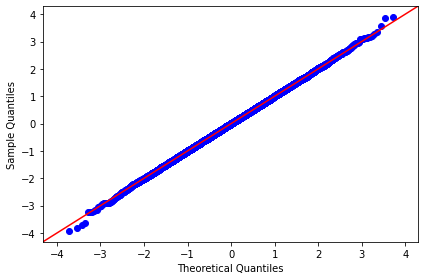

In [13]:
# Residual analysis (residuals should be normally distributed and uncorrelated in order for us to proceed with the model)
# 1. quantile-quantile plot (Q-Q plot) - to verify if the model’s residuals are normally distributed

from statsmodels.graphics.gofplots import qqplot
qqplot(residuals, line='45') #Specify the display of the line y = x

plt.tight_layout()

C:\Users\Edwin\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


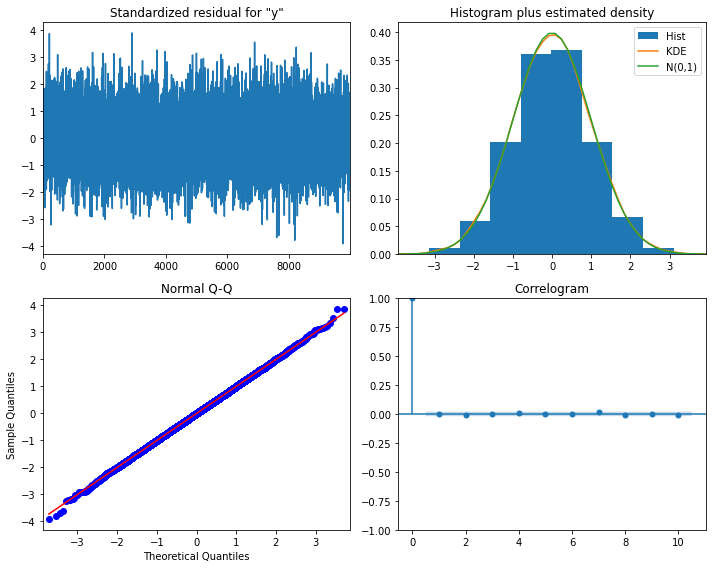

In [14]:
# The QQ-plot depicts a normal distribution 
# Now analyze the correlogram to see if there are significant coefficients

model_fit.plot_diagnostics(figsize=(10,8))

plt.tight_layout()

In [15]:
# top-left plot shows no trend, and the mean seems constant over time, meaning that our residuals are likely stationary. 
# The top right displays a density plot with a shape similar to that of a normal distribution. 
# The Q-Q plot at the bottom left shows a thick straight line that is very close to y = x. 
# Finally, the ACF plot at the bottom right shows no autocorrelation after lag 0.

In [16]:
# Perform a quantitative analysis of the residuals by applying the Ljung-Box test on the first 10 lags
# Finally apply the Ljung-Box test to quantitatively assess whether our residuals are indeed uncorrelated.
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)
lbvalue.columns = ['stat', 'p-value']
lbvalue

,stat,p-value
1,0.042293,0.837061
2,0.429510,0.806739
3,0.588119,0.899147
4,0.727302,0.947920
5,0.740199,0.980690
6,0.906759,0.988901
7,2.563799,0.922217
8,3.162964,0.923718
9,3.258722,0.953148
10,3.642107,0.962052


In [17]:
# The resulting list of p-values shows that each is above 0.05. Therefore, at each lag, 
# the null hypothesis cannot be rejected, meaning that the residuals are independently distributed and uncorrelated

In [18]:
# Use the rolling_forecast function to make predictions using the selected
# ARMA(p,q) model, the mean method, and the last known value method

In [19]:
# Forecasting bandwidth usage
# use the ARMA(2,2) model to forecast the next 2 timesteps

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
        return pred_ARMA

In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

,Value,pred_mean,pred_last_value,pred_ARMA
9800,-0.275170,-0.025645,-0.837188,-1.182182
9801,0.479336,-0.025645,-0.837188,-1.137223
9802,3.059285,-0.025619,0.479336,0.736508
9803,2.459694,-0.025619,0.479336,0.627930
9804,2.941582,-0.025051,2.459694,2.100925


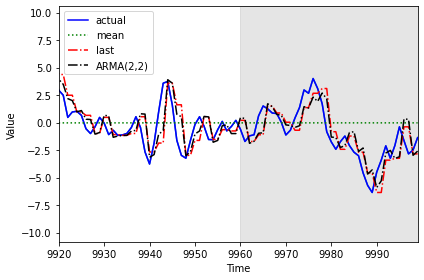

In [21]:
fig, ax = plt.subplots()

ax.plot(df['Value'])
ax.plot(test['Value'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k-.', label='ARMA(2,2)')
ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Value')

ax.axvspan(9960, 9999, color='#808080', alpha=0.2)

ax.set_xlim(9920, 9999)  #Zoom in on the testing period

fig.autofmt_xdate
plt.tight_layout()

In [22]:
# Calculate the mean squared error (MSE) to evaluate the performance of each model
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_mean = mean_squared_error(test['Value'], test['pred_mean'])
mse_last = mean_squared_error(test['Value'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['Value'], test['pred_ARMA'])
print(mse_mean, mse_last, mse_ARMA)

6.263912001945173 2.1552606973982593 1.7598494206642368


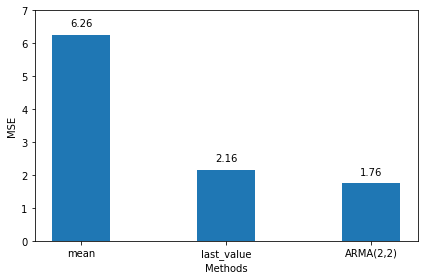

In [23]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARMA(2,2)']
y = [mse_mean, mse_last, mse_ARMA] 

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MSE')
ax.set_ylim(0, 7)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.25, s=str(round(value, 2)), ha='center')

plt.tight_layout()

In [24]:
# The ARMA(2,2) model outperforms the benchmarks

In [25]:
# record end time

end = dt.now()
elapsed = end-start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:09:34
